In [2]:
from Reader import Reader
import copy
import json
import sys
import os
import time
import pickle
from glob import glob
import argparse
import _pickle as cPickle
import subprocess as sp
import multiprocessing as mp
from collections import deque

import numpy as np
import pandas as pd
import keras
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model as lm
import seaborn as sns
from matplotlib import pyplot as plt

from run_model import sandbox, trainScaler, applyScaler

import root_pandas as rp
import uproot

%matplotlib inline

Welcome to JupyROOT 6.18/04


Using TensorFlow backend.
/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/afs/desy.de/user

### Parameters definition

In [3]:
channel = 'mt'
era = '2018'
samples = f'conf/global_config_{channel}_{era}.json'
use = 'keras'

# train = False
# short = True
# datacard = False
# add_nominal = False

In [4]:
read = Reader(channel = channel, config_file = samples, folds=2, era = era)

In [5]:
target_names = read.config["target_names"]
variables = read.config["variables"]

models_folder = era + "/models"
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

modelname = f'{models_folder}/{channel}.{use}'
scaler = None

### Tests for Reader()

In [6]:
read.config['samples']['qqH125']

{'target': 0,
 'select': 'os > 0.5 & byMediumDeepTau2017v2p1VSjet_2 > 0.5 & iso_1 < 0.15',
 'name': '/nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_VBFHToUncorrTauTau_2018.root',
 'event_weight': '( gen_sm_htt125 *  weight * ( 0.95+0.02*( (jpt_1>0 & jpt_1<200) & (njets<2 | ( (jdeta<2.8 | mjj<400 ) & (mjj<60 | mjj>=120 ) ) ) ) - 0.1*(jpt_1>=200) ) * ( 0.8*(gen_match_2 == 5) + 1.*(gen_match_2 !=5) ) )',
 'target_name': 'higgs'}

In [7]:
read.config['target_names']

{0: 'higgs', 1: 'taus', 2: 'fakes', -1: 'none'}

In [8]:
read.config['samples']['W']['target']

2

In [9]:
read.config['samples']['W']['target_name']

'fakes'

### Tests for uproot 

In [15]:
p = '/nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018'
f = uproot.open(f'{p}/mt-NOMINAL_ntuple_Diboson_2018.root')
t = f['TauCheck']

In [23]:
df = t.pandas.df()

In [32]:
df.columns

Index(['run', 'pt_1', 'eta_1', 'phi_1', 'gen_match_1', 'iso_1', 'puppimt_1',
       'ipx_1', 'ipy_1', 'ipz_1', 'IP_signif_PV_with_BS_1', 'pt_2', 'eta_2',
       'phi_2', 'gen_match_2', 'puppimt_2', 'tau_decay_mode_2', 'dmMVA_2',
       'ipx_2', 'ipy_2', 'ipz_2', 'IP_signif_PV_with_BS_2', 'weight', 'njets',
       'mjj', 'jdeta', 'dijetpt', 'jpt_1', 'jpt_2', 'jeta_1', 'jeta_2',
       'm_vis', 'pt_tt', 'mt_tot', 'm_sv', 'pt_sv', 'puppimet', 'os', 'nbtag',
       'byVVVLooseDeepTau2017v2p1VSjet_2', 'byMediumDeepTau2017v2p1VSjet_2',
       'acotautau_refitbs_00', 'acotautau_refitbs_01', 'acotautau_helix_00',
       'acotautau_helix_01', 'xsec_lumi_weight', 'prefiring_weight',
       'htxs_reco_flag_ggh', 'htxs_reco_flag_qqh', 'ff_nom', 'ff_sys',
       'gen_sm_htt125', 'gen_ps_htt125', 'gen_mm_htt125', 'gen_minusmm_htt125',
       'gen_mix0p375_htt125'],
      dtype='object')

In [20]:
# test_filename = 'mt-NOMINAL_ntuple_Diboson_2018.root'
# test_treename = 'TauCheck_CMS_scale_j_BBEC113TeVDown'
test_filename = 'mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root'
test_treename = 'TauCheck'

# mytree = uproot.open(f"{read.config['path']}/{test_filename}")[test_treename]
# mydf = mytree.pandas.df()

#### all branches

In [21]:
%%timeit
df_up = rp.read_root(f"{read.config['path']}/{test_filename}", key=test_treename)

56 s ± 2.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
mytree = uproot.open(f"{read.config['path']}/{test_filename}")[test_treename]
mydf = mytree.pandas.df()

14.5 s ± 254 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### several branches

In [9]:
test_filename = 'mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root'
test_treename = 'TauCheck'

In [10]:
test_branches = ['run', 'pt_1', 'eta_1', 'phi_1', 'gen_match_1', 'iso_1', 'puppimt_1',
       'ipx_1', 'ipy_1', 'ipz_1', 'IP_signif_PV_with_BS_1', 'pt_2', 'eta_2',
       'phi_2', 'gen_match_2', 'puppimt_2', 'tau_decay_mode_2', 'dmMVA_2',
       'ipx_2', 'ipy_2', 'ipz_2', 'IP_signif_PV_with_BS_2', 'weight', 'njets',
       'mjj', 'jdeta', 'dijetpt', 'jpt_1', 'jpt_2', 'jeta_1', 'jeta_2',
       'm_vis', 'pt_tt', 'mt_tot', 'm_sv', 'pt_sv', 'puppimet', 'os', 'nbtag',
       'byVVVLooseDeepTau2017v2p1VSjet_2', 'byMediumDeepTau2017v2p1VSjet_2',
       'acotautau_refitbs_00', 'acotautau_refitbs_01', 'acotautau_helix_00',
       'acotautau_helix_01', 'xsec_lumi_weight', 'prefiring_weight',
       'htxs_reco_flag_ggh', 'htxs_reco_flag_qqh', 'ff_nom', 'ff_sys',
       'gen_sm_htt125', 'gen_ps_htt125', 'gen_mm_htt125', 'gen_minusmm_htt125',
       'gen_mix0p375_htt125']

In [ ]:
%%time
df_rp = rp.read_root(f"{read.config['path']}/{test_filename}", key=test_treename, columns=test_branches[:20])

In [46]:
%%time
mytree_uproot = uproot.open(f"{read.config['path']}/{test_filename}")[test_treename]
df_uproot = mytree_uproot.pandas.df(test_branches[:20])

CPU times: user 4.94 s, sys: 1.19 s, total: 6.13 s
Wall time: 6.03 s


#### one branch

In [24]:
%%timeit
df_up = rp.read_root(f"{read.config['path']}/{test_filename}", columns = 'pt_2', key=test_treename)

1.2 s ± 67.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit
mytree = uproot.open(f"{read.config['path']}/{test_filename}")[test_treename]
mydf = mytree.pandas.df(branches='pt_2')

356 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### **Training data + scaling**

In [16]:
%%time
trainSet = read.getSamplesForTraining()


------> Loading: TJ from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck

size of TJ is 6454

------> Loading: TL from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck

size of TL is 3491

------> Loading: TT from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck

size of TT is 441

------> Loading: TTJ from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck

size of TTJ is 10418

------> Loading: TTL from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck

size of TTL is 52280

------> Loading: TTT from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck

size of TTT is 6609

------> Loading: VVJ from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck

size of VVJ is 1496

------> Loading: VVL from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck

size of VVL is 3680

------> Loading: VVT from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck

size of VVT is 1747

------> Loading: W from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck

size of W is 17842


In [17]:
# scaler = trainScaler(trainSet, variables )
# with open("{0}/StandardScaler.{1}.pkl".format(models_folder,channel), 'wb') as FSO:
#     pickle.dump(scaler, FSO , 2)
# scaler = [scaler, scaler] # Hotfix since KIT uses 2 scalers
# trainSet = applyScaler(scaler, trainSet, variables)

### **Looking into trainSet data**

In [18]:
data = trainSet[1]

In [27]:
data.columns

Index(['pt_1', 'pt_2', 'jpt_1', 'jpt_2', 'dijetpt', 'jdeta', 'njets', 'mjj',
       'm_sv', 'm_vis', 'puppimt_1', 'pt_tt', 'puppimet', 'target',
       'train_weight', 'evt', 'event_weight'],
      dtype='object')

In [28]:
variables

['pt_1',
 'pt_2',
 'jpt_1',
 'jpt_2',
 'dijetpt',
 'jdeta',
 'njets',
 'mjj',
 'm_sv',
 'm_vis',
 'puppimt_1',
 'pt_tt',
 'puppimet']

In [11]:
data.head()

,pt_1,pt_2,jpt_1,jpt_2,dijetpt,jdeta,njets,mjj,m_sv,m_vis,puppimt_1,pt_tt,puppimet,target,train_weight,evt,event_weight
0,35.430485,38.524647,85.788879,54.404617,99.054817,5.777783,2,1229.477173,114.100777,61.547165,38.387241,86.991402,43.591915,0,1.531491,54096030,0.007345
1,37.575989,23.146963,33.665085,-10.000000,-10.000000,-10.000000,1,-10.000000,95.830627,61.432796,37.858597,12.968284,11.158431,0,6.949815,47005890,0.033332
2,28.418978,28.427124,72.718735,55.121967,63.423500,5.822900,2,1166.043823,93.788910,55.832672,0.909472,64.584946,42.913261,0,2.299709,13380000,0.011030
3,54.885571,63.421280,168.467133,48.272121,188.532898,6.934889,2,2890.026611,125.145111,80.235275,0.787615,190.313980,72.013489,0,1.026919,84822422,0.004925
4,34.460537,25.482296,-10.000000,-10.000000,-10.000000,-10.000000,0,-10.000000,87.049591,64.730026,25.465431,25.608828,18.530369,1,276.624783,212580338,184.416522


In [12]:
data.columns

Index(['pt_1', 'pt_2', 'jpt_1', 'jpt_2', 'dijetpt', 'jdeta', 'njets', 'mjj',
       'm_sv', 'm_vis', 'puppimt_1', 'pt_tt', 'puppimet', 'target',
       'train_weight', 'evt', 'event_weight'],
      dtype='object')

In [13]:
np.unique(data.target)

array([0, 1, 2])

### **NaNs**

In [15]:
nan_args = np.argwhere(data.train_weight.isna())
print(f'got {nan_args.shape[0]} NaNs here')

got 2 NaNs here


/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [16]:
data.iloc[nan_args[0]]

,pt_2,jpt_1,jpt_2,njets,m_sv,puppimt_1,pt_tt,mjj,jdeta,dijetpt,target,train_weight,evt,event_weight
410315,-0.048573,0.816373,-0.67431,-0.174887,-0.23011,1.96085,1.37565,-0.485763,-0.764818,-0.609965,0,NaN,60372980,NaN


In [17]:
data.iloc[nan_args[1]]

,pt_2,jpt_1,jpt_2,njets,m_sv,puppimt_1,pt_tt,mjj,jdeta,dijetpt,target,train_weight,evt,event_weight
949281,0.16709,1.430804,0.835269,1.681011,0.159958,0.69868,2.555698,-0.316061,0.770004,1.998089,0,NaN,11831576,NaN


In [34]:
data.columns[(np.sum(data.isna())) != 0].values

array(['train_weight', 'event_weight'], dtype=object)

In [30]:
np.sum(data.isna()).sum()

4

In [149]:
test_filename = 'mt-NOMINAL_ntuple_VBFHToUncorrTauTau_2018.root'
test_treename = 'TauCheck'

In [150]:
mytree = uproot.open(f"{read.config['path']}/{test_filename}")[test_treename]
df = mytree.pandas.df(['gen_sm_htt125', 'evt'])

In [152]:
df[df.isna().values]

,gen_sm_htt125,evt
entry,,
92476,NaN,11831576
1763135,NaN,60372980


In [142]:
11831576 in df.evt.values

True

In [9]:
trainSet[0].dropna(inplace=True)
trainSet[1].dropna(inplace=True)

NameError: name 'trainSet' is not defined

### **Defining model and training**

In [9]:
if use == 'keras':
    from KerasModel import KerasObject as modelObject
    parameters = "conf/parameters_keras.json"
if use == 'xgb':
    from XGBModel import XGBObject as modelObject
    parameters = "conf/parameters_xgb.json"

In [12]:
model = modelObject( parameter_file = parameters,
                             variables=variables,
                             target_names = target_names )


In [13]:
model.params

{'name': 'cp_htt_mt', 'batch_size': 1000, 'epochs': 100, 'early_stopping': 10}

In [14]:
model.variables

['pt_1',
 'pt_2',
 'jpt_1',
 'jpt_2',
 'dijetpt',
 'jdeta',
 'njets',
 'mjj',
 'm_sv',
 'm_vis',
 'puppimt_1',
 'pt_tt',
 'puppimet']

In [ ]:
model.train( trainSet )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1400      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
__________

In [ ]:
model.models

In [ ]:
modelname

In [ ]:
model.__dict__

In [ ]:
# Save models
model.models[0].save(modelname + "_cp_htt_mt_50epochs.fold0")
model.models[1].save(modelname + "_cp_htt_mt_50epochs.fold1")

### **Load model**

In [10]:
if use == 'keras':
    from KerasModel import KerasObject as modelObject
    parameters = "conf/parameters_keras.json"
if use == 'xgb':
    from XGBModel import XGBObject as modelObject
    parameters = "conf/parameters_xgb.json"

In [11]:
model_loaded = modelObject( parameter_file = parameters,
                             variables=variables,
                             target_names = target_names )

In [12]:
model_loaded.models = []
# model_loaded.models.append( lm(modelname + "_v0_30epochs.fold0") )
# model_loaded.models.append( lm(modelname + "_v0_30epochs.fold1") )
model_loaded.models.append( lm(modelname + "_cp_htt_mt_50epochs.fold0") )
model_loaded.models.append( lm(modelname + "_cp_htt_mt_50epochs.fold1") )


2020-02-14 16:49:07.333843: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [13]:
model_loaded.__dict__

{'variables': ['pt_1',
  'pt_2',
  'jpt_1',
  'jpt_2',
  'dijetpt',
  'jdeta',
  'njets',
  'mjj',
  'm_sv',
  'm_vis',
  'puppimt_1',
  'pt_tt',
  'puppimet'],
 'models': [<keras.models.Sequential at 0x2ba521ebe3c8>,
 'params': {'name': 'cp_htt_mt',
  'batch_size': 1000,
  'epochs': 100,
  'early_stopping': 10},
 'target_names': {0: 'higgs', 1: 'taus', 2: 'fakes', -1: 'none'}}

### Prediction

In [14]:
outpath = read.config["outpath"] + "/predictions_" + era
if not os.path.exists(outpath):
    os.mkdir(outpath)    
predictions = {}

In [15]:
# Deleting root files in outpath
files = glob(outpath + '/*.root')
for f in files:
    os.remove(f)

In [19]:
num_cpu = mp.cpu_count()

In [23]:
from concurrent import futures
import ray

In [24]:
ray.init()

@ray.remote
def sandbox(channel, model, scaler, sample, variables, outname, outpath, config = None, modify = None):
    # needed because of memory management
    # iterate over chunks of sample and do splitting on the fly
    first = True
    if sample is None:
        print(f'\nSandbox for sample: {config["histname"]} and tree: {config["tree_name"]} is None. Skipping.\n')
        return
    for i, part in enumerate(sample):
        if config['select'] != "None": # "None" is defined in cuts_{era}.json 
            part.query(config['select'], inplace=True) # sample is iterator - can't filter events in _getDF() so implement it here
            
        # This is awful. Try to figure out a better way to add stuff to generator.
        
        if np.sum(part.isna()).sum() != 0:
            nan_columns = part.columns[(np.sum(part.isna())) != 0].values
            drop_nan_columns = config["drop_nan_columns"]
            print('\n**********')
            print(f'Sample {config["histname"]} has in {i}th chunk {np.sum(part.isna()).sum()} NaNs in columns: {nan_columns}')
            if any(elem in nan_columns for elem in drop_nan_columns):    
                print(f'Will drop them for {drop_nan_columns}\n')
                part.dropna(subset=drop_nan_columns, inplace=True)
            else:
                print(f'\nLeaving them, dropping is set only for {drop_nan_columns}')
            print('**********\n')
            
        if modify:
            modify(part, config)

        part["THU"] = 1 # Add dummy
        # Carefull!! Check if splitting is done the same for training. This is the KIT splitting
        folds = [part.query( "abs(evt % 2) != 0 " ).reset_index(drop=True), part.query( "abs(evt % 2) == 0 " ).reset_index(drop=True) ]
        predictions = pd.concat(model.predict( [fold[variables] for fold in folds] ), axis=0)
        folds = pd.concat(folds, axis=0)
        df = pd.concat([folds, predictions], axis=1).reset_index()
        
        outfile_name = "{0}/{1}-{2}.root".format(outpath, channel, outname)
        df.to_root(outfile_name, key=config['tree_name'], mode = 'a')

        # print('pt_1 = ', folds[0].pt_1[0])
        # print('pt_1 = ', folds[1].pt_1[0])
        # addPrediction(channel, model.predict( [fold[variables] for fold in folds] ), folds, outname, config['tree_name'], outpath, new = first )
        
        folds.drop(folds.index, inplace=True)
        # folds[0].drop(folds[0].index, inplace=True)
        # folds[1].drop(folds[1].index, inplace=True)
        part.drop(part.index, inplace=True)

        first = False
    del sample


2020-02-14 18:39:37,127	WARNING worker.py:673 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2020-02-14 18:39:37,131	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-14 18:39:37,140	INFO resource_spec.py:216 -- Starting Ray with 150.24 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
E0214 18:39:40.156497 22761 raylet_client.cc:114] Retrying to connect to socket for pathname /tmp/ray/session_2020-02-14_18-39-37_130341_22761/sockets/raylet (num_attempts = 1, num_retries = 5)


In [25]:
results = [sandbox.remote(channel, model_loaded, scaler, sample, variables,  "NOMINAL_ntuple_" + sampleConfig["histname"].split("_")[0], outpath, sampleConfig, read.modifyDF) for sample, sampleConfig in read.get(what = "full", add_jec = True, for_prediction = True)]


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVUp



TypeError: can't pickle _thread.lock objects


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVUp



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVUp



TypeError: can't pickle _thread.lock objects


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVUp



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVUp



    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_Absolute_201813TeVUp



TypeError: can't pickle _thread.lock objects


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_HF_201813TeVUp



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_EC2_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_RelativeSample_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_BBEC1_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_Absolute_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_HF_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_EC2_201813TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_RelativeSample_201813TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_BBEC1_201813TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects


------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVUp



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVUp



TypeError: can't pickle _thread.lock objects


------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVUp


Couldnt find TauCheck_CMS_scale_j_FlavorQCD13TeVUp tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVUp


Couldnt find TauCheck_CMS_scale_j_RelativeBal13TeVUp tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVUp


Couldnt find TauCheck_CMS_scale_j_HF13TeVUp tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVUp


Couldnt find TauCheck_CMS_scale_j_BBEC113TeVUp tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVUp


Couldnt find TauCheck_CMS_scale_j_EC213TeVUp tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects


------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVUp


Couldnt find TauCheck_CMS_scale_j_Absolute13TeVUp tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_Absolute_201813TeVUp


Couldnt find TauCheck_CMS_scale_j_Absolute_201813TeVUp tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects


------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_HF_201813TeVUp


Couldnt find TauCheck_CMS_scale_j_HF_201813TeVUp tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_EC2_201813TeVUp


Couldnt find TauCheck_CMS_scale_j_EC2_201813TeVUp tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_RelativeSample_201813TeVUp


Couldnt find TauCheck_CMS_scale_j_RelativeSample_201813TeVUp tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_BBEC1_201813TeVUp


Couldnt find TauCheck_CMS_scale_j_BBEC1_201813TeVUp tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVDown


Couldnt find TauCheck_CMS_scale_j_FlavorQCD13TeVDown tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects


------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVDown


Couldnt find TauCheck_CMS_scale_j_RelativeBal13TeVDown tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVDown


Couldnt find TauCheck_CMS_scale_j_HF13TeVDown tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVDown


Couldnt find TauCheck_CMS_scale_j_BBEC113TeVDown tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVDown


Couldnt find TauCheck_CMS_scale_j_EC213TeVDown tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects


------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVDown


Couldnt find TauCheck_CMS_scale_j_Absolute13TeVDown tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_Absolute_201813TeVDown


Couldnt find TauCheck_CMS_scale_j_Absolute_201813TeVDown tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_HF_201813TeVDown


Couldnt find TauCheck_CMS_scale_j_HF_201813TeVDown tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_EC2_201813TeVDown


Couldnt find TauCheck_CMS_scale_j_EC2_201813TeVDown tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_RelativeSample_201813TeVDown


Couldnt find TauCheck_CMS_scale_j_RelativeSample_201813TeVDown tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects


------> Loading: EMB_full from mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, tree = TauCheck_CMS_scale_j_BBEC1_201813TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



Couldnt find TauCheck_CMS_scale_j_BBEC1_201813TeVDown tree in /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root, skipping it



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck



TypeError: can't pickle _thread.lock objects


------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVUp



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects


------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVUp



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVUp



    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVUp



    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_Absolute_201813TeVUp



TypeError: can't pickle _thread.lock objects


------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_HF_201813TeVUp



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_EC2_201813TeVUp



2020-02-14 18:41:12,847	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86360, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_RelativeSample_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_BBEC1_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects


------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects


------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_Absolute_201813TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects
2020-02-14 18:41:13,866	ERROR worker.py:994 -- Pos

TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
2020-02-14 18:41:13,879	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86360, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
2020-02-14 18:41:13,881	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86360, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute


------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_HF_201813TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_EC2_201813TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects


------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_RelativeSample_201813TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ST_full from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck_CMS_scale_j_BBEC1_201813TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError


------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVUp



: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVUp



2020-02-14 18:41:14,889	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86368, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
2020-02-14 18:41:14,892	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86371, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.

TypeError: can't pickle _thread.lock objects

2020-02-14 18:41:14,893	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86409, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
2020-02-14 18:41:14,896	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86371, ip=131.169.160.114)
  File "python/ray/_rayl


------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVUp



2020-02-14 18:41:14,937	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86350, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
2020-02-14 18:41:14,948	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86417, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.

TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
2020-02-14 18:41:14,971	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86363, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serializ


------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_Absolute_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_HF_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_EC2_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_RelativeSample_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_BBEC1_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects
2020-02-14 18:41:15,985	ERROR worker.py:994 -- Pos


------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_Absolute_201813TeVDown



2020-02-14 18:41:16,013	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86363, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
2020-02-14 18:41:16,015	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86427, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.

TypeError: can't pickle _thread.lock objects

2020-02-14 18:41:16,028	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86433, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
2020-02-14 18:41:16,033	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86349, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute


------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_HF_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_EC2_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_RelativeSample_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: TT_full from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck_CMS_scale_j_BBEC1_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck



TypeError: can't pickle _thread.lock objects


------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVUp



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVUp



TypeError: can't pickle _thread.lock objects


------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVUp



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVUp



    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVUp



    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVUp



    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_Absolute_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_HF_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_EC2_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects
2020-02-14 18:41:17,048	ERROR worker.py:994 -- Pos


------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_RelativeSample_201813TeVUp



2020-02-14 18:41:17,073	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86403, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
2020-02-14 18:41:17,074	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86428, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.

TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
2020-02-14 18:41:17,087	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86438, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
2020-02-14 18:41:17,088	ERROR worker.py:


------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_BBEC1_201813TeVUp



2020-02-14 18:41:17,134	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86364, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
2020-02-14 18:41:17,135	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86405, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.

TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
2020-02-14 18:41:17,150	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
2020-02-14 18:41:17,152	ERROR worker.py:


------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVDown



2020-02-14 18:41:17,182	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
2020-02-14 18:41:17,188	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.

TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_Absolute_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_HF_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_EC2_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_RelativeSample_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: VV_full from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck_CMS_scale_j_BBEC1_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects
2020-02-14 18:41:18,223	ERROR worker.py:994 -- Pos


------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVUp



2020-02-14 18:41:18,244	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
2020-02-14 18:41:18,246	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.

TypeError: can't pickle _thread.lock objects

2020-02-14 18:41:18,268	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put

2020-02-14 18:41:18,272	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute


------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_Absolute_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_HF_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_EC2_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_RelativeSample_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_BBEC1_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVDown



TypeError: can't pickle _thread.lock objects

2020-02-14 18:41:19,303	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put

    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serializ


------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVDown



2020-02-14 18:41:19,325	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
2020-02-14 18:41:19,367	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.

TypeError: can't pickle _thread.lock objects

2020-02-14 18:41:19,386	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
2020-02-14 18:41:19,388	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute


------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_Absolute_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_HF_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_EC2_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_RelativeSample_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: W_full from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck_CMS_scale_j_BBEC1_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: data_full from mt-NOMINAL_ntuple_SingleMuon_2018.root, tree = TauCheck



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    2020-02-14 18:41:20,392	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
 


------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVUp



2020-02-14 18:41:20,464	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
2020-02-14 18:41:20,467	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.

TypeError: can't pickle _thread.lock objects

2020-02-14 18:41:20,468	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
2020-02-14 18:41:20,470	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute


------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_Absolute_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_HF_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_EC2_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_RelativeSample_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_BBEC1_201813TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
2020-02-14 18:41:21,476	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  


------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVDown



2020-02-14 18:41:21,533	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
2020-02-14 18:41:21,536	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.

TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
2020-02-14 18:41:21,555	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serializ


------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_Absolute_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_HF_201813TeVDown



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_EC2_201813TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_RelativeSample_201813TeVDown



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: ggH125_full from mt-NOMINAL_ntuple_GluGluHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_BBEC1_201813TeVDown



TypeError: can't pickle _thread.lock objects


------> Loading: qqH125_full from mt-NOMINAL_ntuple_VBFHToUncorrTauTau_2018.root, tree = TauCheck



Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects


TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: qqH125_full from mt-NOMINAL_ntuple_VBFHToUncorrTauTau_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: qqH125_full from mt-NOMINAL_ntuple_VBFHToUncorrTauTau_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: qqH125_full from mt-NOMINAL_ntuple_VBFHToUncorrTauTau_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: qqH125_full from mt-NOMINAL_ntuple_VBFHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: qqH125_full from mt-NOMINAL_ntuple_VBFHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
    value, protocol=5, buffer_callback=writer.buffer_callback)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 68, in dumps
    cp.dump(obj)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 557, in dump
    return Pickler.dump(self, obj)
TypeError: can't pickle _thread.lock objects



------> Loading: qqH125_full from mt-NOMINAL_ntuple_VBFHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVUp



TypeError: can't pickle _thread.lock objects

Exception ignored in: 'ray._raylet.prepare_args'
Traceback (most recent call last):
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 1493, in put
    object_id = worker.put_object(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/worker.py", line 277, in put_object
    serialized_value = self.get_serialization_context().serialize(value)
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/serialization.py", line 485, in serialize
2020-02-14 18:41:22,577	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    


------> Loading: qqH125_full from mt-NOMINAL_ntuple_VBFHToUncorrTauTau_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVUp



2020-02-14 18:41:22,655	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
2020-02-14 18:41:22,657	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.

KeyboardInterrupt: 

2020-02-14 18:41:23,667	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/ray/signature.py", line 167, in recover_args
    "Flattened arguments need to be even-numbered. See `flatten_args`.")
AssertionError: Flattened arguments need to be even-numbered. See `flatten_args`.
2020-02-14 18:41:23,672	ERROR worker.py:994 -- Possible unhandled error from worker: ray_worker (pid=86365, ip=131.169.160.114)
  File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 630, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 521, in ray._raylet.deserialize_args
  File "/afs/desy.de/user/f/filatovo/.

In [22]:
with futures.ProcessPoolExecutor() as pool:
    pool.map(sandbox, [(channel, model_loaded, scaler, sample, variables,  "NOMINAL_ntuple_" + sampleConfig["histname"].split("_")[0], outpath, sampleConfig, read.modifyDF) for sample, sampleConfig in read.get(what = "full", add_jec = True, for_prediction = True) ])


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVUp


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVUp


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVUp


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVUp


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVUp


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVUp


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVUp


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVUp


------> Loading: DY_full fro

Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/queues.py", line 234, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib64/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
TypeError: can't pickle _thread.lock objects
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/queues.py", line 234, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib64/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
TypeError: can't pickle _thread.lock objects
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/queues.py", line 234, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib64/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
TypeError: can't pickle _thread.lock objects
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/queues.p

KeyboardInterrupt: 

  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-210:
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process Process-275:
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceba

In [ ]:
%%time    
for sample, sampleConfig in read.get(what = "full", add_jec = True, for_prediction = True):
    if "data" in sampleConfig["histname"]:
        sandbox(channel, model_loaded, scaler, sample, variables, "NOMINAL_ntuple_SingleMuon_2018", outpath, sampleConfig, read.modifyDF)
    elif "full" in sampleConfig["histname"]:
        sandbox(channel, model_loaded, scaler, sample, variables,  "NOMINAL_ntuple_" + sampleConfig["histname"].split("_")[0], outpath, sampleConfig, read.modifyDF )
    else:
        splName = sampleConfig["histname"].split("_")
        sandbox(channel, model_loaded, scaler, sample, variables,  "_".join(splName[1:])+"_ntuple_" + sampleConfig["histname"].split("_")[0], outpath, sampleConfig, read.modifyDF )


------> Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck


**********
Sample DY_full has in 0th chunk 2291 NaNs in columns: ['IP_signif_PV_with_BS_2' 'acotautau_refitbs_00' 'acotautau_refitbs_01'
 'acotautau_helix_00' 'acotautau_helix_01']

Leaving them, dropping is set only for ['gen_sm_htt125', 'gen_ps_htt125', 'gen_mm_htt125']
**********


**********
Sample DY_full has in 1th chunk 2359 NaNs in columns: ['IP_signif_PV_with_BS_2' 'acotautau_refitbs_00' 'acotautau_refitbs_01'
 'acotautau_helix_00' 'acotautau_helix_01']

Leaving them, dropping is set only for ['gen_sm_htt125', 'gen_ps_htt125', 'gen_mm_htt125']
**********


**********
Sample DY_full has in 2th chunk 2452 NaNs in columns: ['IP_signif_PV_with_BS_2' 'acotautau_refitbs_00' 'acotautau_refitbs_01'
 'acotautau_helix_00' 'acotautau_helix_01']

Leaving them, dropping is set only for ['gen_sm_htt125', 'gen_ps_htt125', 'gen_mm_htt125']
**********


**********
Sample DY_full has in 3th chunk 2573 NaNs in c

### Tests with NN predictions

In [45]:
DY_predict_up = rp.read_root(outpath + '/mt-NOMINAL_ntuple_DY.root', key='TauCheck_CMS_scale_j_HF13TeVUp')
DY_predict_down = rp.read_root(outpath + '/mt-NOMINAL_ntuple_DY.root', key='TauCheck_CMS_scale_j_HF13TeVDown')
DY_predict_center = rp.read_root(outpath + '/mt-NOMINAL_ntuple_DY.root', key='TauCheck')

In [16]:
ggH_predict_up = rp.read_root(outpath + '/mt-NOMINAL_ntuple_ggH125.root', key='TauCheck_CMS_scale_j_HF13TeVUp')
ggH_predict_down = rp.read_root(outpath + '/mt-NOMINAL_ntuple_ggH125.root', key='TauCheck_CMS_scale_j_HF13TeVDown')
ggH_predict_center = rp.read_root(outpath + '/mt-NOMINAL_ntuple_ggH125.root', key='TauCheck')

In [46]:
sns.distplot(DY_predict_up.predicted_prob, label='Up', hist=False)
sns.distplot(DY_predict_down.predicted_prob, label='Down', hist=False)
sns.distplot(DY_predict_center.predicted_prob, label='Center', hist=False)
plt.legend()
plt.title('DY')

Text(0.5, 1, 'DY')

Text(0.5, 1.0, 'ggH')

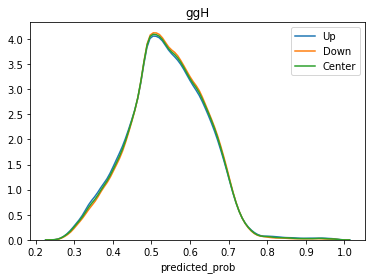

In [18]:
sns.distplot(ggH_predict_up.predicted_prob, label='Up', hist=False)
sns.distplot(ggH_predict_down.predicted_prob, label = 'Down', hist=False)
sns.distplot(ggH_predict_center.predicted_prob, label = 'Center', hist=False)
plt.legend()
plt.title('ggH')